In [12]:
import riotwatcher as rw
from pprint import pprint
from time import sleep
import io, json
import numpy as np
from collections import defaultdict
import math

import pymongo
from pymongo import MongoClient

from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.lda import LDA

from matplotlib import pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

In [19]:
with open("api-key.txt", 'r') as f:
    key = f.readlines()[0]
    

In [20]:
call = rw.RiotWatcher(key)

In [21]:
# Get champion id to name dict
response = call.static_get_champion_list()

champ_dict = {}
for c in response['data'].keys():
    champ_dict[response['data'][c]['id']] = c

HTTPError: 403 Client Error: Forbidden for url: https://global.api.pvp.net/api/lol/static-data/na/v1.2/champion?api_key=9e427fe0-ddc4-4318-8d94-b1aeb3b59bb2%0A

200


In [16]:
# get challenger ids
challenger = call.get_challenger()
challenger_ids = map(lambda x: (x['playerOrTeamId'],x['playerOrTeamName']), challenger['entries'])

#get na master tier
c9_hai = "492066"
league = call.get_league(summoner_ids = [c9_hai])
master_ids = map(lambda x: (x['playerOrTeamId'],x['playerOrTeamName']), league[c9_hai][0]['entries'])

summoners = list(set(challenger_ids + master_ids))
with io.open('summoner_ids.txt', 'w', encoding='utf-8') as f:
        f.write(unicode(json.dumps(summoners, ensure_ascii=False)))

HTTPError: 403 Client Error: Forbidden for url: https://na.api.pvp.net/api/lol/na/v2.5/league/challenger?api_key=9e427fe0-ddc4-4318-8d94-b1aeb3b59bb2%0A&type=RANKED_SOLO_5x5

In [12]:
games = []
for begin in [0,15]:
    for (summoner_id,name) in summoners:
        while call.can_make_request() == False:
            sleep(0.1)
        try:
            games.append(call.get_match_list(summoner_id, ranked_queues = ['RANKED_SOLO_5x5', 'RANKED_PREMADE_5x5'], begin_index=begin, end_index=begin+15 ))
        except Exception:
            print "error for ", summoner_id, name



error for  34022147 Tuesday Chicken
805


In [19]:
match_ids = []
for i in games:
    try:
        match_ids += map(lambda x: x["matchId"], i["matches"])
    except Exception:
        pass

{u'endIndex': 15,
 u'matches': [{u'champion': 78,
               u'lane': u'TOP',
               u'matchId': 2079018152,
               u'platformId': u'NA1',
               u'queue': u'RANKED_SOLO_5x5',
               u'region': u'NA',
               u'role': u'SOLO',
               u'season': u'SEASON2016',
               u'timestamp': 1453753592798},
              {u'champion': 127,
               u'lane': u'MID',
               u'matchId': 2078807968,
               u'platformId': u'NA1',
               u'queue': u'RANKED_SOLO_5x5',
               u'region': u'NA',
               u'role': u'SOLO',
               u'season': u'SEASON2016',
               u'timestamp': 1453712728866},
              {u'champion': 133,
               u'lane': u'TOP',
               u'matchId': 2078802979,
               u'platformId': u'NA1',
               u'queue': u'RANKED_SOLO_5x5',
               u'region': u'NA',
               u'role': u'SOLO',
               u'season': u'SEASON2016',
           

In [24]:
all_matches = list(set(match_ids))
len(all_matches)

In [47]:
with io.open('match_ids.txt', 'w', encoding='utf-8') as f:
    f.write(unicode(json.dumps(sorted(all_matches), ensure_ascii=False)))

In [11]:
with io.open('match_ids.txt', 'r', encoding='utf-8') as f:
    all_matches = json.load(f)

In [5]:
client = MongoClient('localhost', 27017)
db = client.jungle_gravity
collection = db.challenger_games

In [43]:
all_matches = sorted(all_matches)
failed_matches = []
for i in range(0, len(all_matches)):
    while call.can_make_request() == False:
        sleep(0.1)
    try:
        match = call.get_match(int(all_matches[i]), include_timeline=True)
        collection.insert_one(match)
    except Exception:
        print "could not retrieve match", all_matches[i]
        failed_matches.append(all_matches[i])
        
    if i % 100 == 0:
        print i

print "Finished retrieving matches"
print "Succesful: ", len(all_matches)-len(failed_matches)
print "Failed:    ", len(failed_matches)
print "Rate:      ", 1 - (len(failed_matches)*1.0 / len(all_matches))
    

could not retrieve match 237127963
0
could not retrieve match 1220928865
could not retrieve match 1263231352
could not retrieve match 1263242718
could not retrieve match 1263271365
could not retrieve match 1263291154
could not retrieve match 1263308793
could not retrieve match 1263310124
could not retrieve match 1263361622
could not retrieve match 1263472632
could not retrieve match 1263548868
could not retrieve match 1263647259
could not retrieve match 1263734964
could not retrieve match 1263901485
could not retrieve match 1263926132
could not retrieve match 1278827337
could not retrieve match 1278937825
could not retrieve match 1279162325
could not retrieve match 1279201979
could not retrieve match 1279249934
could not retrieve match 1279275736
could not retrieve match 1279434372
could not retrieve match 1279507245
could not retrieve match 1279856429
could not retrieve match 1280327710
could not retrieve match 1281776427
could not retrieve match 1285031638
could not retrieve match 12

In [46]:
# Helper Functions
BLUE = 100
RED = 200

def is_gravitated(p1, p2):
    distance = math.sqrt( abs(p1["x"] - p2["x"]) ** 2 + abs(p1["y"] - p2["y"]) ** 2 )
    return distance <= 2000

def get_positions(frame):
    positions = {}
    for player, info in frame["participantFrames"].items():
        positions[int(player)] = info["position"]
    return positions

def get_champions(participants):
    champions = {}
    for player in participants:
        champions[player["participantId"]] = player["championId"]
    return champions

def get_roles(participants):
    blue = {}
    red = {}
    for player in participants:
        num = player["participantId"]
        team = player["teamId"]
        lane = player["timeline"]["lane"]
        role = player["timeline"]["role"]
        
        if lane == "TOP":
            position = "TOP"
            
        elif lane == "MIDDLE":
            position = "MID"
        
        elif lane == "BOTTOM":
            if role == "DUO_CARRY":
                position = "ADC"
            elif role == "DUO_SUPPORT":
                position = "SUPPORT"
            else:
                print "Something is wrong"
                print role
                return None
        
        elif lane == "JUNGLE":
            position = "JUNGLE"
        
        else:
            #print "Something is wrong"
            #print lane, role
            return None

        if team is BLUE:
            blue[position] = num
        else:
            red[position] = num
    
    if len(blue.keys()) + len(red.keys()) == 10:
        return (blue, red)
    else:
        #print "not every role filled"
        #print blue, red
        return None
        
    

In [98]:
MINUTE = 60000

blue_jungle_gravity = defaultdict(lambda: 0)
blue_minute_gravity = defaultdict(lambda: defaultdict(lambda: 0))
red_jungle_gravity = defaultdict(lambda: 0)
red_minute_gravity = defaultdict(lambda: defaultdict(lambda: 0))
total_games = 0
champion_games = defaultdict(lambda: 0)
champion_minute_gravity = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))

cursor = collection.find()
while(cursor.alive):
    document = cursor.next()
    roles = get_roles(document["participants"])
    if roles and document.get("timeline", None):
        blue, red = roles
        champions = get_champions(document["participants"])

        total_games += 1
        if total_games % 100 == 0:
            print total_games
        #if total_games == 1000:
        #    break
            
        blue_jungler = blue["JUNGLE"]
        red_jungler = red["JUNGLE"]
        champion_games[champions[blue_jungler]] += 1
        champion_games[champions[red_jungler]] += 1

        for frame in document["timeline"]["frames"][3:16]:
            time = frame["timestamp"]/MINUTE
            #print frame
            positions = get_positions(frame)
            #print positions
            
            for player in blue.keys():
                if positions.get(blue[player], None) and is_gravitated(positions[blue_jungler], positions[blue[player]]):
                    blue_jungle_gravity[player] += 1
                    blue_minute_gravity[time][player] += 1
                    champion_minute_gravity[champions[blue_jungler]][time][player] += 1
                                            
            for player in red.keys():
                if positions.get(red[player], None) and is_gravitated(positions[red_jungler], positions[red[player]]):
                    red_jungle_gravity[player] += 1
                    red_minute_gravity[time][player] += 1
                    
                    champion_minute_gravity[champions[red_jungler]][time][player] += 1
                    
                    
                

Something is wrong
DUO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
SOLO
Something is wrong
DUO
Something is wrong
SOLO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
SOLO
Something is wrong
DUO
Something is wrong
SOLO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
SOLO
Something is wrong
SOLO
Something is wrong
DUO
Something is wrong
SOLO
Something is wrong
SOLO
Something is wrong
DUO
Something is wrong
SOLO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
SOLO
Something is wrong
DUO
Something is wrong
SOLO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
DUO
Something is wrong
SOLO
Something is wrong
DUO
Something is wrong
SOLO
Something is wrong
DUO
Something is wrong
SOLO
Something is wrong
DUO
Something is wrong
S

In [34]:
blue_jungle_gravity

defaultdict(<function <lambda> at 0x10976cde8>, {'SUPPORT': 1849, 'MID': 2416, 'JUNGLE': 12987, 'TOP': 1207, 'ADC': 1485})

In [35]:
blue_minute_gravity

defaultdict(<function <lambda> at 0x10b5ca6e0>, {3: defaultdict(<function <lambda> at 0x10b5ca8c0>, {'SUPPORT': 24, 'MID': 136, 'JUNGLE': 999, 'TOP': 3, 'ADC': 18}), 4: defaultdict(<function <lambda> at 0x10b5ca1b8>, {'SUPPORT': 41, 'TOP': 112, 'JUNGLE': 999, 'ADC': 33, 'MID': 138}), 5: defaultdict(<function <lambda> at 0x10b5cacf8>, {'TOP': 90, 'SUPPORT': 70, 'JUNGLE': 999, 'ADC': 80, 'MID': 169}), 6: defaultdict(<function <lambda> at 0x10b5ca320>, {'SUPPORT': 110, 'MID': 153, 'JUNGLE': 999, 'TOP': 78, 'ADC': 97}), 7: defaultdict(<function <lambda> at 0x10b5ca398>, {'SUPPORT': 126, 'MID': 173, 'JUNGLE': 999, 'TOP': 64, 'ADC': 96}), 8: defaultdict(<function <lambda> at 0x10b5ca578>, {'SUPPORT': 95, 'TOP': 47, 'JUNGLE': 999, 'ADC': 82, 'MID': 149}), 9: defaultdict(<function <lambda> at 0x10b5caf50>, {'SUPPORT': 142, 'TOP': 74, 'JUNGLE': 999, 'ADC': 115, 'MID': 157}), 10: defaultdict(<function <lambda> at 0x10b5cade8>, {'TOP': 116, 'SUPPORT': 119, 'JUNGLE': 999, 'ADC': 103, 'MID': 192}),

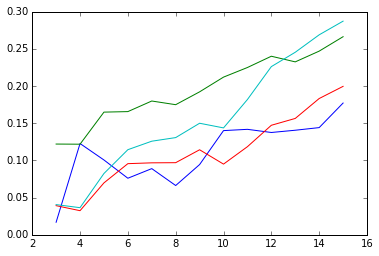

In [99]:
x = range(3,16)
y_top = map(lambda y: blue_minute_gravity[y]["TOP"]*1.0/total_games, x)
y_mid = map(lambda y: blue_minute_gravity[y]["MID"]*1.0/total_games, x)
y_adc = map(lambda y: blue_minute_gravity[y]["ADC"]*1.0/total_games, x)
y_sup = map(lambda y: blue_minute_gravity[y]["SUPPORT"]*1.0/total_games, x)

plt.plot(x,y_top)
plt.plot(x,y_mid)
plt.plot(x,y_adc)
plt.plot(x,y_sup)
plt.show()

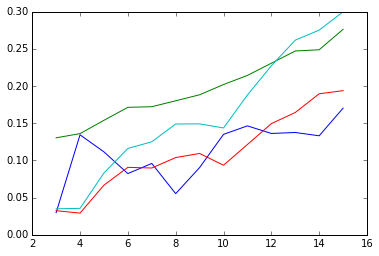

In [100]:
x = range(3,16)
y_top = map(lambda y: red_minute_gravity[y]["TOP"]*1.0/total_games, x)
y_mid = map(lambda y: red_minute_gravity[y]["MID"]*1.0/total_games, x)
y_adc = map(lambda y: red_minute_gravity[y]["ADC"]*1.0/total_games, x)
y_sup = map(lambda y: red_minute_gravity[y]["SUPPORT"]*1.0/total_games, x)

plt.plot(x,y_top)
plt.plot(x,y_mid)
plt.plot(x,y_adc)
plt.plot(x,y_sup)
plt.show()

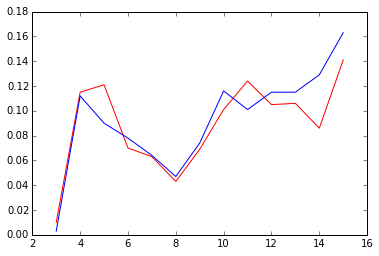

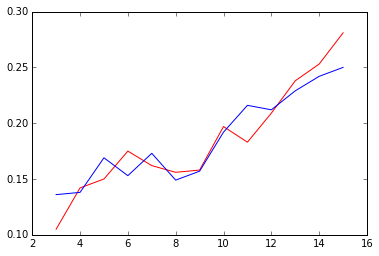

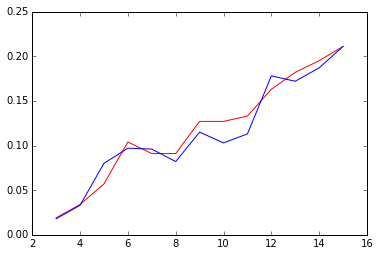

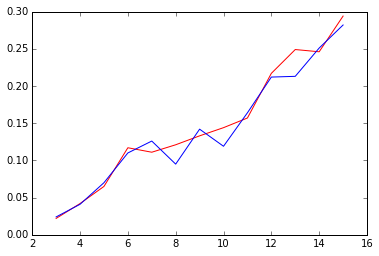

In [71]:
for role in ["TOP","MID", "ADC", "SUPPORT"]:
    x = range(3,16)
    y_red = map(lambda y: red_minute_gravity[y][role]*1.0/total_games, x)
    y_blue = map(lambda y: blue_minute_gravity[y][role]*1.0/total_games, x)
    plt.plot(x,y_red, color='r')
    plt.plot(x,y_blue, color = 'b')
    plt.show()

In [73]:
champion_games

defaultdict(<function <lambda> at 0x10b5b9de8>, {1: 34, 2: 4, 4: 20, 5: 12, 6: 10, 7: 44, 8: 20, 9: 12, 10: 4, 11: 14, 12: 14, 13: 2, 14: 16, 15: 18, 16: 18, 17: 10, 18: 18, 19: 16, 20: 22, 21: 6, 22: 6, 23: 16, 24: 6, 25: 28, 26: 6, 27: 2, 28: 4, 29: 6, 30: 12, 31: 14, 32: 10, 33: 4, 34: 4, 35: 42, 36: 2, 37: 26, 38: 14, 39: 26, 40: 50, 41: 12, 42: 28, 43: 4, 44: 2, 45: 12, 50: 2, 51: 32, 53: 36, 54: 14, 55: 6, 56: 4, 57: 20, 58: 22, 59: 16, 60: 10, 61: 14, 62: 8, 64: 54, 67: 38, 68: 14, 69: 10, 72: 8, 74: 10, 75: 26, 76: 48, 77: 14, 78: 8, 79: 8, 80: 12, 81: 50, 82: 2, 83: 6, 84: 4, 85: 10, 86: 6, 89: 36, 90: 2, 91: 16, 92: 28, 96: 10, 98: 8, 99: 14, 101: 26, 102: 8, 103: 24, 104: 44, 105: 16, 106: 2, 107: 22, 110: 2, 111: 12, 112: 4, 113: 4, 114: 16, 115: 10, 117: 32, 119: 14, 120: 20, 121: 18, 122: 10, 126: 10, 127: 12, 131: 16, 133: 6, 134: 8, 3211: 0, 143: 6, 150: 28, 154: 6, 157: 22, 161: 18, 201: 12, 222: 40, 236: 42, 238: 18, 254: 26, 266: 2, 267: 20, 268: 20, 412: 58, 421: 30

In [102]:
champions = call.static_get_champion_list()["data"]


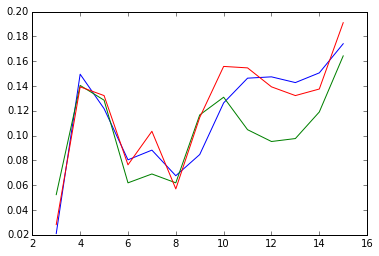

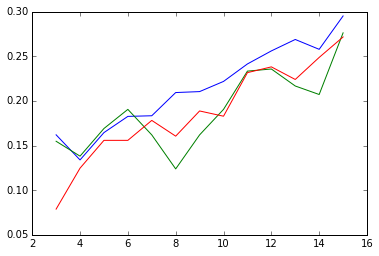

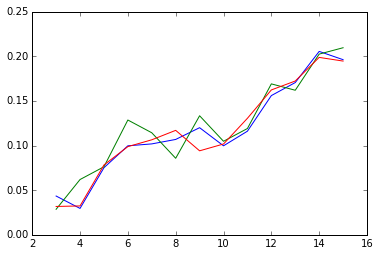

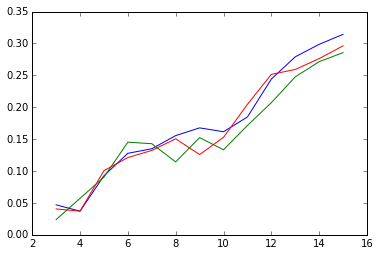

In [104]:
x = range(3,16)
for role in ["TOP","MID", "ADC", "SUPPORT"]: 
    for champ in ["LeeSin", "Shaco", "Nidalee"]:
        champ_id = champions[champ]["id"]
        jg = champion_minute_gravity[champ_id]
        y_top = map(lambda y: jg[y][role]*1.0/champion_games[champ_id], x)
        plt.plot(x, y_top)
    plt.show()

In [81]:
champions

{u'Aatrox': {u'id': 266,
  u'key': u'Aatrox',
  u'name': u'Aatrox',
  u'title': u'the Darkin Blade'},
 u'Ahri': {u'id': 103,
  u'key': u'Ahri',
  u'name': u'Ahri',
  u'title': u'the Nine-Tailed Fox'},
 u'Akali': {u'id': 84,
  u'key': u'Akali',
  u'name': u'Akali',
  u'title': u'the Fist of Shadow'},
 u'Alistar': {u'id': 12,
  u'key': u'Alistar',
  u'name': u'Alistar',
  u'title': u'the Minotaur'},
 u'Amumu': {u'id': 32,
  u'key': u'Amumu',
  u'name': u'Amumu',
  u'title': u'the Sad Mummy'},
 u'Anivia': {u'id': 34,
  u'key': u'Anivia',
  u'name': u'Anivia',
  u'title': u'the Cryophoenix'},
 u'Annie': {u'id': 1,
  u'key': u'Annie',
  u'name': u'Annie',
  u'title': u'the Dark Child'},
 u'Ashe': {u'id': 22,
  u'key': u'Ashe',
  u'name': u'Ashe',
  u'title': u'the Frost Archer'},
 u'Azir': {u'id': 268,
  u'key': u'Azir',
  u'name': u'Azir',
  u'title': u'the Emperor of the Sands'},
 u'Bard': {u'id': 432,
  u'key': u'Bard',
  u'name': u'Bard',
  u'title': u'the Wandering Caretaker'},
 u'Blit